# Install Dependencies


In [ ]:
!pip install tensorflow==2.15.0 keras==2.15 tensorflow-hub==0.13.0 tensorflow-text==2.15.0
!pip install datasets
!pip -q install evaluate
!pip install imbalanced-learn

# Import Libraries

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.layers import Input

import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



# Tensor Flow

import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef



# Check if libraries are installed and print their versions
try:
    print(f"TensorFlow Hub Version: {hub.__version__}")
except ImportError:
    print("TensorFlow Hub is not installed.")

try:
    print(f"TensorFlow Text Version: {text.__version__}")
except ImportError:
    print("TensorFlow Text is not installed.")

try:
    print(f"TensorFlow Version: {tf.__version__}")
except ImportError:
    print("TensorFlow is not installed.")

try:
    print(f"pandas Version: {pd.__version__}")
except ImportError:
    print("pandas is not installed.")

try:
    print(f"scikit-learn Version: {train_test_split.__module__.split('.')[0]}")
except ImportError:
    print("scikit-learn is not installed.")

try:
    print(f"scikit-learn Version: {classification_report.__module__.split('.')[0]}")
except ImportError:
    print("scikit-learn is not installed.")

#other usefull

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import RandomOverSampler


TensorFlow Hub Version: 0.13.0
TensorFlow Text Version: 2.15.0
TensorFlow Version: 2.15.0
pandas Version: 2.2.2
scikit-learn Version: sklearn
scikit-learn Version: sklearn


# Import Github

In [3]:
!git clone https://github.com/tajuar-akash-hub/Datasets.git

Cloning into 'Datasets'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 40 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 3.87 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (11/11), done.


# Dataset Location

In [5]:
my_df_loc = '/kaggle/working/Datasets/generated_with_gemini.csv'

#  AlBERT

In [10]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
import evaluate

In [11]:
# Load dataset
data = pd.read_csv(my_df_loc)
data.dropna(inplace=True)

In [12]:
data.columns

Index(['Generated_using_gemini', 'index_number', 'ClaimLegitimacy',
       'fraud_status'],
      dtype='object')

# Train test split 

In [14]:
# Split into training and test datasets
train_data, test_data = train_test_split(data, stratify=data['fraud_status'], test_size=0.2, random_state=42)


In [16]:
# Apply RandomOverSampler only to the training data
ros = RandomOverSampler(random_state=42)

# Perform oversampling on the training data
X_train_resampled, y_train_resampled = ros.fit_resample(train_data[['Generated_using_gemini']], train_data['fraud_status'])

# Combine the resampled features and target back into a DataFrame
train_data_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1).reset_index(drop=True)


In [17]:
# Ensure test data remains untouched
X_test = test_data['Generated_using_gemini'].tolist()
y_test = test_data['fraud_status'].tolist()


In [18]:
# Extract training texts and labels

train_texts = train_data_resampled['Generated_using_gemini'].tolist()
train_labels = train_data_resampled['fraud_status'].tolist()


In [23]:
# Print class distribution for verification
print("Class distribution in resampled training set:")
print(train_data_resampled['fraud_status'].value_counts())
print("Class distribution in test set:")
print(test_data['fraud_status'].value_counts())


Class distribution in resampled training set:
fraud_status
0    2744
1    2744
Name: count, dtype: int64
Class distribution in test set:
fraud_status
0    687
1     45
Name: count, dtype: int64


In [24]:
# Tokenization
from transformers import AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

train_encodings = tokenizer(
    train_texts, padding="max_length", truncation=True, max_length=128, return_tensors="np"
)
test_encodings = tokenizer(
    X_test, padding="max_length", truncation=True, max_length=128, return_tensors="np"
)


In [26]:
# Convert labels to numpy arrays
import numpy as np
train_labels = np.array(train_labels)
test_labels = np.array(y_test)


In [27]:
# Create HuggingFace datasets
from datasets import Dataset

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})

In [43]:
# Model Training
from transformers import AlbertForSequenceClassification, Trainer, TrainingArguments

model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="none",
)

def compute_metrics(eval_preds):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
        "f1": f1_score(labels, predictions, average="weighted"),
        "mcc": matthews_corrcoef(labels, predictions),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-43-57a82bc03d2a>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [44]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mcc
1,No log,0.248665,0.872951,0.931355,0.872951,0.895662,0.363373
2,0.446800,0.418361,0.915301,0.953362,0.915301,0.928498,0.551322
3,0.108800,0.269323,0.954918,0.955391,0.954918,0.955149,0.613373
4,0.108800,0.316648,0.954918,0.955391,0.954918,0.955149,0.613373
5,0.020800,0.399418,0.956284,0.950895,0.956284,0.949557,0.540733
6,0.005700,0.370835,0.961749,0.959825,0.961749,0.955122,0.603360
7,0.005700,0.368794,0.961749,0.957997,0.961749,0.957215,0.613768
8,0.000000,0.374244,0.960383,0.956165,0.960383,0.956012,0.601314
9,0.000000,0.371843,0.960383,0.956243,0.960383,0.956635,0.606912
10,0.000000,0.372405,0.960383,0.956243,0.960383,0.956635,0.606912


TrainOutput(global_step=3430, training_loss=0.08486070040282155, metrics={'train_runtime': 731.8902, 'train_samples_per_second': 74.984, 'train_steps_per_second': 4.686, 'total_flos': 327881956147200.0, 'train_loss': 0.08486070040282155, 'epoch': 10.0})

In [45]:
# Evaluate the model

results = trainer.evaluate()
print("Evaluation Results:", results)


Evaluation Results: {'eval_loss': 0.24866518378257751, 'eval_accuracy': 0.8729508196721312, 'eval_precision': 0.9313554854144905, 'eval_recall': 0.8729508196721312, 'eval_f1': 0.8956618146636325, 'eval_mcc': 0.3633727313357125, 'eval_runtime': 3.0629, 'eval_samples_per_second': 238.991, 'eval_steps_per_second': 15.019, 'epoch': 10.0}


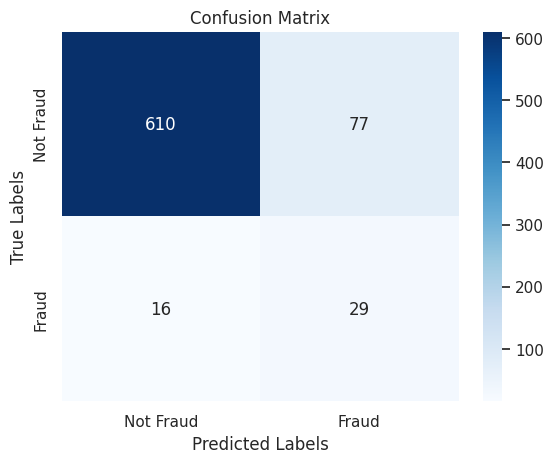

In [46]:
# Confusion Matrix

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

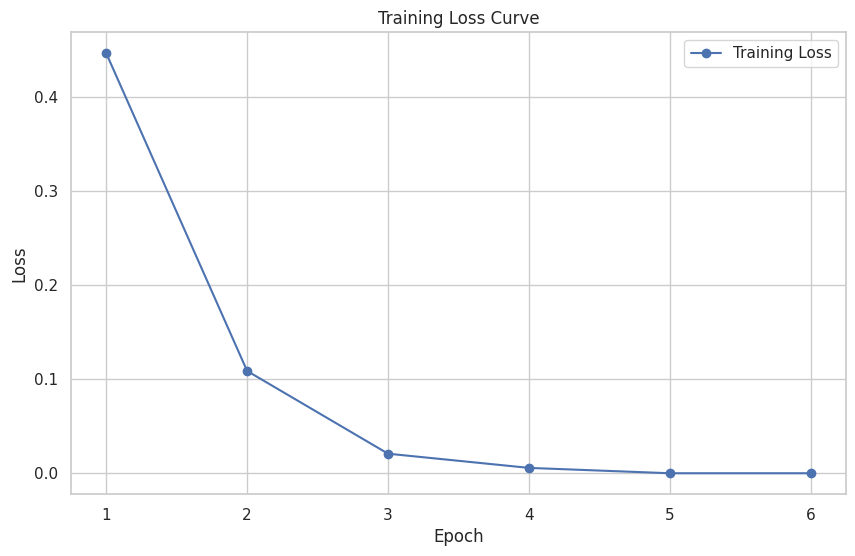

In [47]:
# Training Loss Curve

training_logs = trainer.state.log_history
train_loss = [log["loss"] for log in training_logs if "loss" in log]
epochs = list(range(1, len(train_loss) + 1))
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, marker='o', linestyle='-', label='Training Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

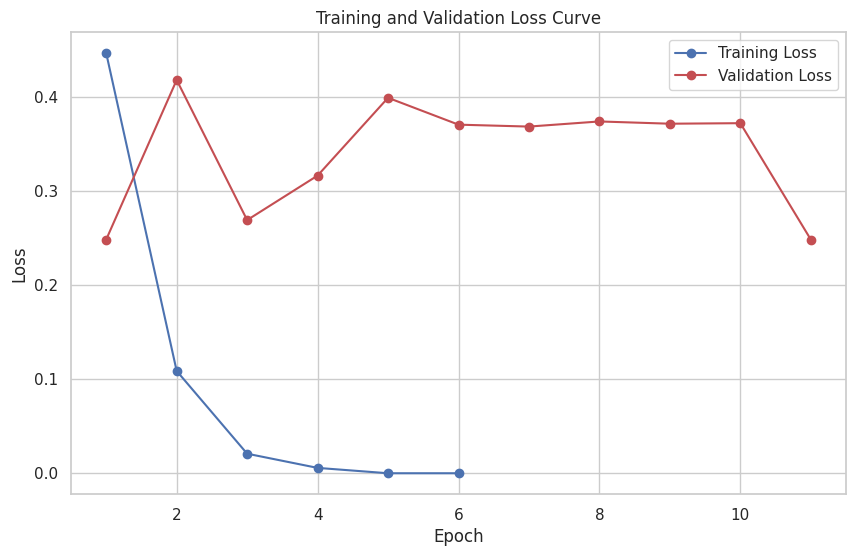

In [48]:
# Train-Validation Loss Curve

val_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
epochs_val = list(range(1, len(val_loss) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, marker='o', linestyle='-', label='Training Loss', color='b')
plt.plot(epochs_val, val_loss, marker='o', linestyle='-', label='Validation Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

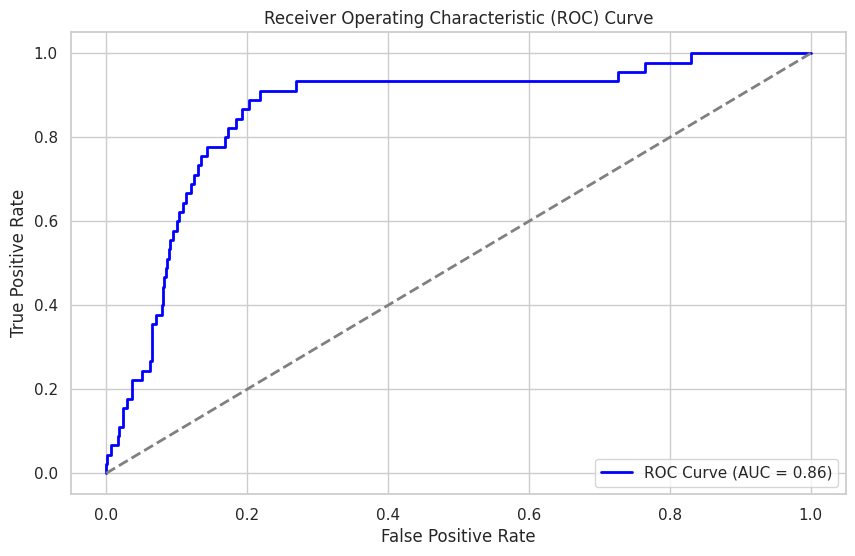

In [49]:
# ROC Curve

predicted_probabilities = predictions.predictions[:, 1]
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()